### Create the data

https://cs231n.github.io/convolutional-networks/
https://medium.com/apache-mxnet/multi-channel-convolutions-explained-with-ms-excel-9bbf8eb77108

In [22]:
import random
import torch
from torch import nn, optim
import math
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
from cycler import cycler
import matplotlib.style
import matplotlib as mpl
from mpl_toolkits import mplot3d 

nn.Module comes in handy while writing many DL model. For example when you are trying to code Maxout Network as defined in the paper [Maxout Networks] (https://arxiv.org/pdf/1302.4389.pdf 44).
https://github.com/pytorch/pytorch/commit/c7c8aaa7f040dd449dbc6aca9204b2f943aef477
https://discuss.pytorch.org/t/multiple-parallel-fully-connected-layers-type-torch-cuda-floattensor-but-found-type-torch-floattensor/37810
https://www.geeksforgeeks.org/single-neuron-neural-network-python/
https://rhettinger.wordpress.com/2011/05/26/super-considered-super/


In [23]:
%matplotlib notebook
import glob, os, os.path
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
import bisect
import scipy.sparse as sparse  #for baseline subtraction
from matplotlib import rc
rc('mathtext', default='regular')
import h5py

In [24]:
'''Definitions'''

def gaussian(x, x0, r, a, b):
    y = b + a*np.exp(-(x-x0)**2/(2*r**2))
    return y

def PseudoVoigtFunction(WavNr, Pos, Amp, GammaL, FracL):
    SigmaG = GammaL / np.sqrt(2*np.log(2)) # Calculate the sigma parameter  for the Gaussian distribution from GammaL (coupled in Pseudo-Voigt)
    LorentzPart = Amp / np.pi * (GammaL / ((WavNr - Pos)**2 + GammaL**2)) # Lorentzian distribution
    GaussPart = Amp / (np.sqrt(2*np.pi) * SigmaG) * np.exp( -(WavNr - Pos)**2 / (2 * SigmaG**2)) # Gaussian distribution
    Fit = FracL * LorentzPart + (1 - FracL) * GaussPart # Linear combination of the two parts (or distributions)
    return Fit

#baseline subtraction based on Asymetric Least Square Smoothing
#https://zanran_storage.s3.amazonaws.com/www.science.uva.nl/ContentPages/443199618.pdf
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = sparse.linalg.spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

# Function which extracts the number of all XYfiles in the directory.    
run_no=0
def get_number_XYfiles(run_no):
    directory = os.listdir('data/')
    number_XYfiles = run_no
    for Dir in directory:
        number_XYfiles = number_XYfiles+1
    return(number_XYfiles)

In [25]:
# show the number of XYfiles found in the directory
total_XYfiles = get_number_XYfiles(run_no)
print(total_XYfiles)
total_XYfiles=350 #[Pt=1084, MgFeOB1_263]
print('The number of XYfiles within the chosen run is:', total_XYfiles)
%pwd
%mkdir -p ClassificationFigures
save_figures_to = '../ClassificationFigures/'

350
The number of XYfiles within the chosen run is: 350


In [27]:
'''make sure that you have the right command directory selected'''
%cd /gpfs/exfel/data/user/sunyue/Spectra_classification_20201122/data/
theta = [] 
I = []
baseline = []
Icorrect = []

test_y=total_XYfiles-2
for run_no in range(1,0+total_XYfiles):
    fileNO = str(run_no).zfill(4) 
    fname = 'l2_fe80mg20_ramp_00001_m1_'+str(run_no).zfill(4)+'.xy'
    thetas, Is = np.loadtxt(fname, skiprows=25, unpack=True) # reads all files in range and assigns 1st column to thetas and 2nd to Is
    I.append(Is) # attaches a new array each time to a copy of previous, not really necessary here
    idx1 = 0
    idx2 = 4050
#background subtraction
#parameters lam and p have to be adjusted by hand!
#try 10**2 < lam < 10**9
#    0.001 <  p  < 0.1
    lam = 100000
    p = 0.002
    baselines = baseline_als(Is[idx1:idx2], lam, p)
    baseline.append(baselines)
    Icorrected = Is[idx1:idx2] - baselines
    Icorrect.append(Icorrected)
#    if (run_no==15): 
#        print(thetas.size, Is.shape,type(I),np.shape(I),len(Icorrected),len(baselines),sep='\n')
    thetas = thetas[idx1:idx2]
    theta.append(thetas)

/gpfs/exfel/data/user/sunyue/Spectra_classification_20201122/data


In [28]:
print(theta[0].shape,np.size(theta),len(theta),np.size(theta[0]))

(4023,) 1404027 349 4023


In [29]:
%cd -
%pwd

/gpfs/exfel/data/user/sunyue/Spectra_classification_20201122


'/gpfs/exfel/data/user/sunyue/Spectra_classification_20201122'

<IPython.core.display.Javascript object>


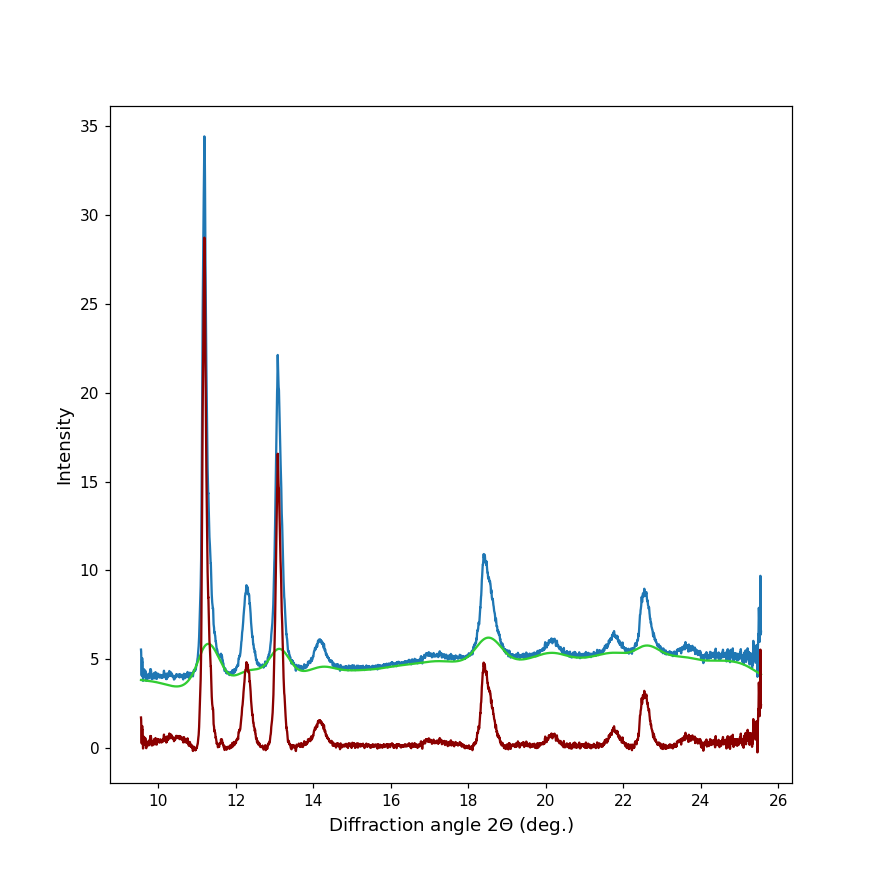

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

In [30]:
plt.figure()
plt.plot(theta[98], I[98][idx1:idx2])
plt.plot(theta[98], baseline[98],color = 'limegreen')
plt.plot(theta[98], Icorrect[98], color = 'darkred')
#plt.plot(theta[0], I[0], color = 'red')
#plt.plot(theta[1500], I[1500][idx1:idx2])
#plt.plot(theta[1500], baseline[1500])
#plt.plot(theta[450], Icorrect[450], color = 'limegreen')
#plt.plot(theta[420], I[420], color = 'limegreen')
plt.ylabel('Intensity', fontsize = 12)
plt.xlabel('Diffraction angle 2$\Theta$ (deg.)', fontsize = 12)
plt.tight_layout

In [31]:
def minibatch_plot_data(X, y, ai1=-1,ai2=1,bi1=-1,bi2=1,d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
#     plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=2, cmap=plt.cm.rainbow)
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=2, cmap=plt.cm.rainbow)
#     plt.axis('square')
#     plt.axis(np.array((ai1, ai2, bi1, bi2)) * zoom)
#     if auto is True: plt.axis('equal')
    plt.axis('on') 
    
def minibatch_plot_model(mndinx1,mndinx2,mndiny1,mndiny2,X2, y2, model):
    model.cpu()
#     nx, ny = (200, 200)
#     x = np.linspace(mndinx1, mndinx2, nx)
#     y = np.linspace(mndiny1,mndiny2, ny)
    x = np.arange(mndinx1, mndinx2, 0.02)
    y = np.arange(mndiny1, mndiny2, 0.001)
    xx, yy = np.meshgrid(x, y)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
    minibatch_plot_data(X2, y2,mndinx1,mndinx2,mndiny1,mndiny2,zoom=1)

In [32]:
def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
#     plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_ylabel('Intensity', )#fontsize = 16,
    ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)', )#fontsize = 16
#     plt.axis(np.array((axl, axr, byl, byh)) * zoom)
    
    plt.rc('xtick') #,labelsize=16
    plt.rc('ytick') #,labelsize=16
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=0.4, cmap=plt.cm.rainbow)

In [33]:
def set_default(figsize=(8, 8)):
#     plt.style.use(['dark_background', 'bmh'])
#     plt.rc('figure', facecolor='none')
    plt.rc('figure', figsize=figsize)
    
def yue_plot_data(X, y, axl,axr,byl,byh,d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
#     plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.set_ylabel('Intensity', fontsize = 16,)
    ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)', fontsize = 16)
    plt.axis(np.array((axl, axr, byl, byh)) * zoom)
    #ax.set_ylim(-2,50)
    #ax.set_xlim(9.5,26)
    
    plt.rc('xtick',labelsize=16)
    plt.rc('ytick',labelsize=16)
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=0.6, cmap=plt.cm.rainbow)
    #plt.axis('auto')      
#     ax.spines['right'].set_visible(False) #remove right axis spine
#     ax.spines['top'].set_visible(False) # remove top axis spine  
    
    """
    X = X.cpu()
    y = y.cpu()
    plt.axis(np.array((axl, axr, byl, byh)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    plt.tight_layout()
    #_m, _c = 0, '.15'
    #plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    #plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)
    """
    """
    cmaps = [('Perceptually Uniform Sequential', [
                'viridis', 'plasma', 'inferno', 'magma', 'cividis']),
             ('Sequential', [
                'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
             ('Sequential (2)', [
                'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
                'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
                'hot', 'afmhot', 'gist_heat', 'copper']),
             ('Diverging', [
                'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
                'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
             ('Cyclic', ['twilight', 'twilight_shifted', 'hsv']),
             ('Qualitative', [
                'Pastel1', 'Pastel2', 'Paired', 'Accent',
                'Dark2', 'Set1', 'Set2', 'Set3',
                'tab10', 'tab20', 'tab20b', 'tab20c']),
             ('Miscellaneous', [
                'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
                'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
                'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])]
    """

def ys_plot_model(X, y, model):
    plt.figure(figsize=(8,8))
    bx = plt.subplot(111)
#     bx.set_ylabel('Intensity', fontsize = 16,)
#     bx.set_xlabel('Diffraction angle 2$\Theta$ (deg.)', fontsize = 16)
    plt.axis([axl, axr, byl, byh])
    
#     plt.rc('xtick',labelsize=16)
#     plt.rc('ytick',labelsize=16)
    
    model.cpu()
    X=X.cpu()
    mesh1 = np.arange(axl, axr, 0.01)
    mesh2 = np.arange(byl, byh, 0.01)
    xx, yy = np.meshgrid(mesh1, mesh2)
    
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float().cpu()
        Z = model(data).detach()
        #print(xx,Z.shape,Zt,data.shape)
    Z = np.argmax(Z, axis=1).reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)     
    yue_plot_data(X, y, axl,axr,byl,byh)
    
    
def yue_plot_3D(X, X_axis):
    X = X.cpu()
    X_axis = X_axis.cpu()    
    
    fig = plt.figure(figsize = (10, 7)) 
    ax = plt.axes(projection ="3d") 

    # Creating plot 
    ax.scatter3D(X_axis.numpy(), X.numpy()[:, 0], X.numpy()[:, 1],s=0.3, color = "green"); 
    
    plt.title("Spectra 3D scatter plot") 
    ax.set_xlabel('X-axis', fontweight ='bold')  
    ax.set_ylabel('angle', fontweight ='bold')  
    ax.set_zlabel('intensity', fontweight ='bold') 

    # show plot 
    plt.show() 

In [34]:
set_default()

In [35]:

Spec_len = np.size(theta[0])


D = 2  # dimensions
C = 2  # num_classes
H = 150 # num_hidden_units



# seed = 12345
# random.seed(seed)
# torch.manual_seed(seed)

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#  data for training

In [37]:
# train NN in each bin
def TrainingProc():
    global X2,y2
    X2 = torch.zeros(N2 * N_Train, D*B).to(device)
    y2 = torch.zeros(N2 * N_Train, 1, dtype=torch.float).to(device)    
    
    for b in range(B):
        for ix in range(N2):
            for ic in range(N_Train):
                X2[ix+ic*N2,2*b:2*b+2] = X_Extrem[b*N2+ix+ic*N]
                y2[ix+ic*N2] = y_Extrem[b*N2+ix+ic*N]
    #print("X2:", tuple(X2.size()))
    #print("y2:", tuple(y2.size()))
    #print('y2.shape',y2.shape)
    
    learning_rate = 2e-3  # 8e-3
    lambda_l2 = 2e-5
    # nn package to create our linear model
    # each Linear module has a weight and bias

    # nn package also has different loss functions.
    # we use cross entropy loss for our classification task
    criterion = torch.nn.BCELoss()

    # we use the optim package to apply
    # ADAM for our parameter updates
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
    #optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate, betas=(0.8, 0.999), eps=1e-08, weight_decay=0) # built-in L2

    # e = 1.  # plotting purpose

    # Training
    dh=display.display("Training",display_id=True)
    for t in range(iternum):
        # Feed forward to get the logits
        y_pred = model(X2)
#         print(y_pred)
        # Compute the loss and accuracy
        loss = criterion(y_pred, y2)
        
        if loss<0.15:
            break
            
        predicted = y_pred > 0.5
        acc = (y2 == predicted).sum().float() / len(y2)
        dh.update(" [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % ( t, loss.item(), acc))
        #display.clear_output(wait=True)
        
        if acc > 0.99:
            break
            
        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()
    
        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()
    
        # Update params
        optimizer.step()
        
        Epoch = t
    #print(len(y2),y_pred.size(),loss,sep='\n') 
    return acc, Epoch
#     return acc,model

In [2]:
############ pick two extreme curves for training===========================================================================
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

global N_Train # number of curves for training
global D_len

N_sim = 15 # simulated spectra

p0_num=  1#0 # 4
p1_num= 13 #7 #13
p2_num= 7 #7 #10 # 9
p3_num= 15#15 # 15
pnum_curves=4  # number of Original spectral curves used for training
N_Train=pnum_curves*(N_sim+1)


iternum = 550
n_feature =20
Numi=N_Train # number of curves for training
B_range= range(1,17)
# B_range= [12]
GLO_Prm  = np.zeros(len(B_range)) # 
GLO_TrnT = np.zeros(len(B_range)) # 
GLO_ACC = np.zeros(len(B_range)) # 
TRN_Epoch = np.zeros(len(B_range)) # 
B_num = np.zeros(len(B_range)) # number of bins
NUM_C0 = np.zeros(len(B_range)) # ambigious region start number
NUM_C1 = np.zeros(len(B_range)) # ambigious region end   number
count=0
for B in B_range:

    
    
    global N2, Acc
    global W, W_np,Xtrain1,Xtrain2
    N2=int(Spec_len/B)
    # N = np.size(theta[0])  # num_samples_per_class
    N = N2*B  # num_samples_per_class
    B_num[count] = B
    N2=int(N/B)
    D_len = N
      
        
        
        
    class MultiBinSegm(nn.Module):
        def __init__(self, input_dim = D*B, output_dim_M = C, output_dim = 1, hidden_size = 150, BinNum = B):
            super().__init__()

            self.fc1nets = nn.ModuleList()
            for _ in range(BinNum):
                Binnet = nn.Sequential(
                    nn.Linear(D, hidden_size),
                    nn.BatchNorm1d(hidden_size),
                    nn.ReLU(),
                    nn.Linear(hidden_size, output_dim_M),
                    nn.BatchNorm1d(output_dim_M),
#                     nn.ReLU(),
                    nn.Sigmoid() # Not ReLU, Sigmoid is used here because we want to consist a classification module.
                )
                self.fc1nets.append(Binnet)

            self.fc2 = nn.Sequential(
                    nn.Linear(D*B, output_dim),
                    nn.Sigmoid()
                )

    #         self.fc2 = nn.Sequential(
    #             nn.Linear(D*B, C),
    #             nn.ReLU(),
    #             nn.Linear(C, output_dim),
    #             nn.Sigmoid()
    #             )

        def forward(self, x):
            Out1 = torch.empty(x.shape[0],0).to(device)
            for b in range(len(self.fc1nets)): # Different input for different bin.
                Out1Bin = self.fc1nets[b](x[:,b*D:(b+1)*D])
                Out1= torch.cat([Out1, Out1Bin], dim=1) 
            Out2 = self.fc2(Out1)
            return Out2


    BATCH_SIZE = N2
    IN_DIM = D*B
    OUT_DimM =C
    OUT_Dim =1  

    model = MultiBinSegm(
        input_dim = IN_DIM,
        output_dim_M = OUT_DimM,
        output_dim = OUT_Dim,
        hidden_size = H,
        BinNum = B,
    )
    model.to(device)


 
    ## trainable parameters in the model 
    for name,param in model.named_parameters():
        print(name,type(param), param.size())
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('pytorch_total_params:',pytorch_total_params)
    
    
    
    #### ============================Generate some training data for training================================================   
    X_1 = []# training: theta
    X_2 = []# training: intensity
    y   = []
    global Ci,Ci_0,div_num,gap #indicates num of curves, and curves of class0.
    div_num = 185 #indicates the boundary of spectral curves.
    gap = 20
    Ci = 0  
    Ci_0 = 0
    for pct in range(0,total_XYfiles,gap):

        Ci += 1
        if pct <div_num:
            Ci_0 += 1

        Icorrect_t = Icorrect[pct]
        theta_t = theta[pct]
        X_1.append(theta_t[0:N])
        X_2.append(Icorrect_t[0:N])    

        
    X_1=torch.FloatTensor(X_1)
    X_2=torch.FloatTensor(X_2)
    
    X_1=torch.reshape(X_1,(-1,1))
    X_2=torch.reshape(X_2,(-1,1))
    X=torch.cat((X_1,X_2),1).to(device)

    y_1 = torch.zeros(Ci_0 * (theta[0].size), dtype=torch.long)
    y_2 = torch.ones((Ci-Ci_0)* (theta[0].size), dtype=torch.long)
    y   = torch.cat((y_1,y_2),0).to(device)
    
    #### ============================Pick Four extreme curves and some simulated ones for training================================================   
 


    D_len=N
    # pick 4 extreme curves to train the model

    Xtemp1=X[D_len*p0_num:D_len+D_len*p0_num,:]
    Xtemp2=X[D_len*p1_num:D_len+D_len*p1_num,:]
    Xtemp3=X[D_len*p2_num:D_len+D_len*p2_num,:]
    Xtemp4=X[D_len*p3_num:D_len+D_len*p3_num,:]
    X_Extrem= torch.empty(0,2)
    X_Extrem=torch.cat((Xtemp1,Xtemp2,Xtemp3,Xtemp4),0)
    X_Extrem_tmp = X_Extrem

    ytemp1=y[D_len*p0_num:D_len+D_len*p0_num]
    ytemp2=y[D_len*p1_num:D_len+D_len*p1_num]
    ytemp3=y[D_len*p2_num:D_len+D_len*p2_num]
    ytemp4=y[D_len*p3_num:D_len+D_len*p3_num]
    y_Extrem=torch.cat((ytemp1,ytemp2,ytemp3,ytemp4),0)

#     N_sim=10 # simulated spectra 
    for n in range(N_sim):
        seed = n*1000
        random.seed(seed)
        torch.manual_seed(seed)
        for i in range(D_len*pnum_curves):
            X_Extrem_tmp[i,1] = X_Extrem[i,1] +random.random()/12

        X_Extrem     = torch.cat((X_Extrem,X_Extrem_tmp),0)
        y_Extrem_tmp = torch.cat((ytemp1,ytemp2,ytemp3,ytemp4),0)
        y_Extrem     = torch.cat((y_Extrem,y_Extrem_tmp),0)    

    
   #### ============================Pick two extreme curves and some simulated ones for training================================================           

#     Xtemp1=X[D_len*p0_num:D_len+D_len*p0_num,:]
#     Xtemp2=X[D_len*p1_num:D_len+D_len*p1_num,:]

#     X_Extrem= torch.empty(0,2)
#     X_Extrem=torch.cat((Xtemp1,Xtemp2),0)
#     X_Extrem_tmp = X_Extrem

#     ytemp1=y[D_len*p0_num:D_len+D_len*p0_num]
#     ytemp2=y[D_len*p1_num:D_len+D_len*p1_num]
#     y_Extrem=torch.cat((ytemp1,ytemp2),0)

#     N_sim=10 # simulated spectra 
#     for n in range(N_sim):
#         seed = n*1000
#         random.seed(seed)
#         torch.manual_seed(seed)
#         for i in range(D_len*pnum_curves):
#             X_Extrem_tmp[i,1] = X_Extrem[i,1] +random.random()/12

#         X_Extrem    =torch.cat((X_Extrem,X_Extrem_tmp),0)
#         y_Extrem_tmp=torch.cat((ytemp1,ytemp2),0)
#         y_Extrem    =torch.cat((y_Extrem,y_Extrem_tmp),0)    

        
    #### ============================Generate some testing data ===========================================================   
 

    Spect_1 = torch.empty(0,B) #  theta for test
    Spect_2 = torch.empty(0,B) # intensity for test
    Xt_1= [] #  theta for test
    Xt_2= [] # intensity for test
    yt   = []
    global Ntn,Ntn_0 #indicates num of test curves, and curves of class0.
    Ntn = 0  # num of test curves,
    Ntn_0 = 0 #and num of curves of class0
    pos_d=0
    t_gap=1
    for pct in range(0,total_XYfiles-1,t_gap):
        pct = pct+pos_d
        Ntn += 1
        if pct <div_num:
            Ntn_0 += 1


        Icorrect_t = Icorrect[pct][0:N]
        theta_t = theta[pct][0:N]

        Spect_1= torch.cat((Spect_1,torch.reshape(torch.FloatTensor(theta_t),(-1,N2)).t()),0)
        Spect_2= torch.cat((Spect_2,torch.reshape(torch.FloatTensor(Icorrect_t),(-1,N2)).t()),0)

        Xt_1.append(theta_t)
        Xt_2.append(Icorrect_t)


        
        
    global X2t
    X2t = torch.zeros((Ntn*N2,2*B), dtype=torch.float).to(device)
    n=0
    for b in range(B):
        X2t[:,2*b]=Spect_1[:,b]
        X2t[:,2*b+1]=Spect_2[:,b]
    
    Xt_1=torch.FloatTensor(Xt_1) # convert list type to tensor
    Xt_2=torch.FloatTensor(Xt_2) # convert list type to tensor
    Xt_1=torch.reshape(Xt_1,(-1,1))
    Xt_2=torch.reshape(Xt_2,(-1,1))
    Xt=torch.cat((Xt_1,Xt_2),1).to(device)



    Acc=torch.zeros(B)
    y_pred_union=[]

    ###############============Pick two extreme curves for training============================================================
    from time import time    
    t0= time()
    Acc , Epoch=TrainingProc()  
    t1= time()
    Trntime = t1 - t0
    print("training done in %0.3fs" % (Trntime))
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
    with torch.no_grad(): 
        y_pred= model(X2) 

    ###############============Spectral curves for testing====================================================================
    

    with torch.no_grad(): 
        y2t = model(X2t)# use model in each bin to predict label of test data curves belong to each bin             
    y2t_pred = y2t>0.5 
    yt_prd=torch.reshape(y2t_pred,(Ntn,N2)) # reshape to N2*Ntn
    C0_num = (yt_prd== 0).sum(dim=1) #Count the predicted label value of 0.
    FinlPredLabel = (C0_num> int(N2/C)) #Count the predicted label value of 0.
    FinlPredLabel = 1*(FinlPredLabel==False)


    
    Ct_prid=torch.zeros(N*Ntn, dtype=torch.long).to(device) # predicted test spectra label.
    for j in range(Ntn): # test data sets(curves)  
        for k in range(N):
            Ct_prid[k+j*N]=FinlPredLabel[j] # i represents which bin,c represents which class.
    
    ########### to define the correctly classified interval, and the low confidence interval======================================
    # C_tmp0 = torch.zeros(N, dtype=torch.long).to(device)
    # C_tmp1 = torch.zeros(N, dtype=torch.long).to(device)
   
    var_C0=0
    for j in range(Ntn-1): # test data sets(curves)    
        if Ct_prid[j*N]== 0 and Ct_prid[(j+1)*N]==0:
            var_C0 = j+1
        else:
            break       
#     print(var_C0)   

    var_C1=Ntn-1
    for j in range(Ntn-1,0,-1): # test data sets(curves)   
        if Ct_prid[j*N] == 1 and Ct_prid[(j-1)*N]==1:
            var_C1 = j-1
        else:
            break
#     print(var_C1)  
    glo_acc = 1-float((var_C1-var_C0-1)/Ntn)

    if var_C0==Ntn-1:  # All data belongs to the first category.
        glo_acc = 0
        print("The boundary is not found when B= [%i] and all curves are labeled as 0." % (B))
    elif var_C1==0:    # All data belongs to the second category.
        glo_acc = 0
        print("The boundary is not found when B= [%i] and all curves are labeled as 1." % (B))
    elif var_C0==0 and var_C1==Ntn-1:  
        glo_acc = 0.00
        print("The boundary is not found when B= [%i] and all curves are labeled as 1." % (B))
    else:
        glo_acc = 1-float((var_C1-var_C0-1)/Ntn)
        print("Overall classification accuracy when B= [%i] is %.3f" % (B,glo_acc*100)+"%")    

    print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
    print("Overall classification accuracy is %.3f" % (glo_acc*100)+"%")
    GLO_ACC[count]  = glo_acc
    GLO_Prm[count]  =  pytorch_total_params 
    GLO_TrnT[count] = Trntime # 
    TRN_Epoch[count] =  Epoch

    NUM_C0[count]=var_C0 
    NUM_C1[count]=var_C1
    
    count = count +1
    
    
    if var_C0==Ntn-1:
        p_start0 = 0 # start curve
        p_end0   = Ntn # end curv  
#         p_end0   = Ntn-1 # end curv   
    elif var_C1==0:
        p_start0 = 0 # start curve
        p_end0   = Ntn # end curv 
#         p_end0   = Ntn-1 # end curv   
    else:
        p_start0 = var_C0-5 if var_C0>5 else  var_C0 # start curve
        p_end0   = var_C1+5  if var_C1+5<=Ntn  else Ntn 
#         p_end0   = var_C1+5  if var_C1+5<=Ntn-1 else Ntn-1
    # p_start = p0_num*gap
    # p_end = p_num*gap
    print('showed region: ',p_start0,p_end0)
    
      
    ###########=========================================plot curve near the boundary============================================

    
    D_len=N
    # different type of labels:
    PCt_prid0 = Ct_prid[p_start0*D_len:p_end0*D_len] # Final predict label with model and weights
    PXt0      = torch.zeros((p_end0-p_start0)*D_len,2)
    Xt_temp   = Xt[p_start0*D_len:p_end0*D_len,:]


    n=0
    for j in range(p_start0,p_end0):    
    #     PXt0[(j-p_start0)*D_len:(j+1-p_start0)*D_len,1] = Xt[j*D_len:(j+1)*D_len,1]+6-j/1.
        PXt0[n*D_len:(n+1)*D_len,1] = Xt_temp[n*D_len:(n+1)*D_len,1]+6-j/1.
        PXt0[n*D_len:(n+1)*D_len,0] = Xt_temp[n*D_len:(n+1)*D_len,0]
        n=n+1
    #     print(j,xx)

    
    plt.figure(figsize=(8,6))
    plot_data(PXt0, PCt_prid0)
    plt.title('Final classification result(spectral curves near the boundary),B= %i'% (B))
    plt.savefig(save_figures_to+"'Final classification result(spectral curves near the boundary),B= %i'.png" % (B), bbox_inches='tight', dpi=600)

    
fig, ax = plt.subplots()
ax.plot(B_num, GLO_ACC, 'go-', label='Classification accuracy', linewidth=2)
# ax.plot(B_num, GLO_Prm, 'bo-', label='Trainable parameters', linewidth=2)
# ax.plot(B_num, GLO_TrnT, 'ro-', label='Training time vs Bnum', linewidth=2)
ax.set_ylabel('Final classification confidence', fontsize = 16)
ax.set_xlabel('Number of bins', fontsize = 16)
plt.title("Relationship between confidence and number of bins", fontsize = 16)
plt.legend()
plt.grid(True)
plt.show()
fig.tight_layout()
plt.savefig(save_figures_to+"Relationship between confidence and number of bins.png", bbox_inches='tight', dpi=300)

NameError: name 'random' is not defined

In [39]:
dat = np.array([B_num, GLO_ACC,GLO_Prm,GLO_TrnT, TRN_Epoch])
dat = dat.T
print(dat)
np.savetxt('FCNN Bin-based Classification result vs BIN number.out', dat)


[[1.00000000e+00 9.42693410e-01 1.05900000e+03 7.04754782e+01
  5.49000000e+02]
 [2.00000000e+00 9.88538682e-01 2.11700000e+03 8.21837738e+01
  5.49000000e+02]
 [3.00000000e+00 9.85673352e-01 3.17500000e+03 8.20247581e+01
  5.49000000e+02]
 [4.00000000e+00 9.91404011e-01 4.23300000e+03 8.17652745e+01
  5.49000000e+02]
 [5.00000000e+00 9.94269341e-01 5.29100000e+03 8.17786782e+01
  5.49000000e+02]
 [6.00000000e+00 9.79942693e-01 6.34900000e+03 8.17273359e+01
  5.49000000e+02]
 [7.00000000e+00 9.91404011e-01 7.40700000e+03 7.66248100e+01
  5.07000000e+02]
 [8.00000000e+00 9.91404011e-01 8.46500000e+03 7.25513353e+01
  4.77000000e+02]
 [9.00000000e+00 9.94269341e-01 9.52300000e+03 5.62970004e+01
  3.50000000e+02]
 [1.00000000e+01 9.91404011e-01 1.05810000e+04 3.11672597e+01
  1.55000000e+02]
 [1.10000000e+01 1.00000000e+00 1.16390000e+04 2.53777931e+01
  1.10000000e+02]
 [1.20000000e+01 9.85673352e-01 1.26970000e+04 2.95594234e+01
  1.41000000e+02]
 [1.30000000e+01 9.94269341e-01 1.375500

In [40]:
fname = 'FCNN Bin-based Classification result vs BIN number.out'
B_num, GLO_ACC ,GLO_Prm, GLO_TrnT, TRN_Epoch= np.loadtxt(fname, unpack=True) # reads all files in range and assigns 1st column to thetas and 2nd to Is
print(B_num,GLO_ACC,GLO_Prm,GLO_TrnT, TRN_Epoch)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.] [0.94269341 0.98853868 0.98567335 0.99140401 0.99426934 0.97994269
 0.99140401 0.99140401 0.99426934 0.99140401 1.         0.98567335
 0.99426934 0.98567335 1.         1.        ] [ 1059.  2117.  3175.  4233.  5291.  6349.  7407.  8465.  9523. 10581.
 11639. 12697. 13755. 14813. 15871. 16929.] [70.47547817 82.18377376 82.0247581  81.76527452 81.77867818 81.72733593
 76.62480998 72.55133533 56.29700041 31.16725969 25.37779307 29.55942345
 27.99714565 19.36641479 17.67743254 20.90527773] [549. 549. 549. 549. 549. 549. 507. 477. 350. 155. 110. 141. 129.  63.
  50.  74.]


<IPython.core.display.Javascript object>


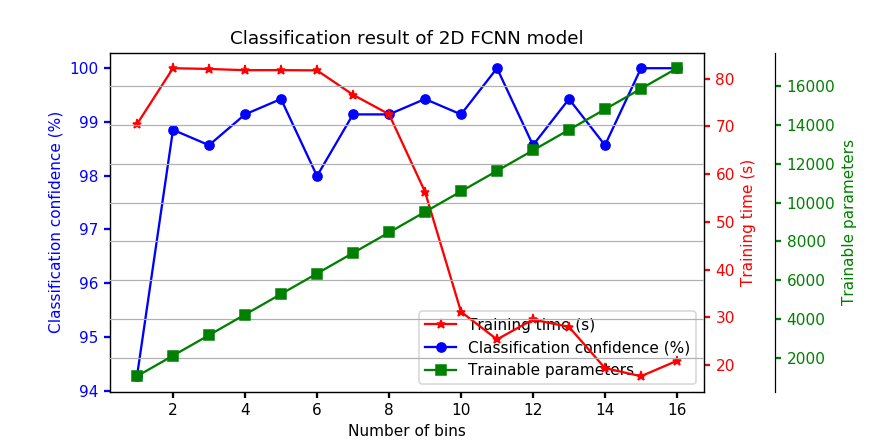

In [41]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, host = plt.subplots(figsize=(8,4))
fig.subplots_adjust(right=0.8)

par1 = host.twinx()
par2 = host.twinx()

par2.spines["right"].set_position(("axes", 1.12))
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)

p1, = host.plot(B_num, GLO_ACC *100,'bo-',color='blue',label='Classification confidence (%)')
p1_1, = par1.plot(B_num, GLO_TrnT,'*-',color='red',label='Training time (s)')
p2, = par2.plot(B_num, GLO_Prm,'gs-',color='green',label='Trainable parameters')

host.set_xlabel("Number of bins")
host.set_ylabel("Classification confidence (%)")
par1.set_ylabel("Training time (s)")
par2.set_ylabel("Trainable parameters")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p1_1.get_color())
par2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p1_1.get_color(), **tkw)
par2.tick_params(axis='y', colors=p2.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

# par1.set_ylim(170,180)

lines = [p1_1,p1, p2]

host.legend(lines, [l.get_label() for l in lines],loc='below right')
plt.title('Classification result of 2D FCNN model')
plt.grid(True)
plt.savefig(save_figures_to+"Classification result of 2D FCNN model.svg")

<IPython.core.display.Javascript object>


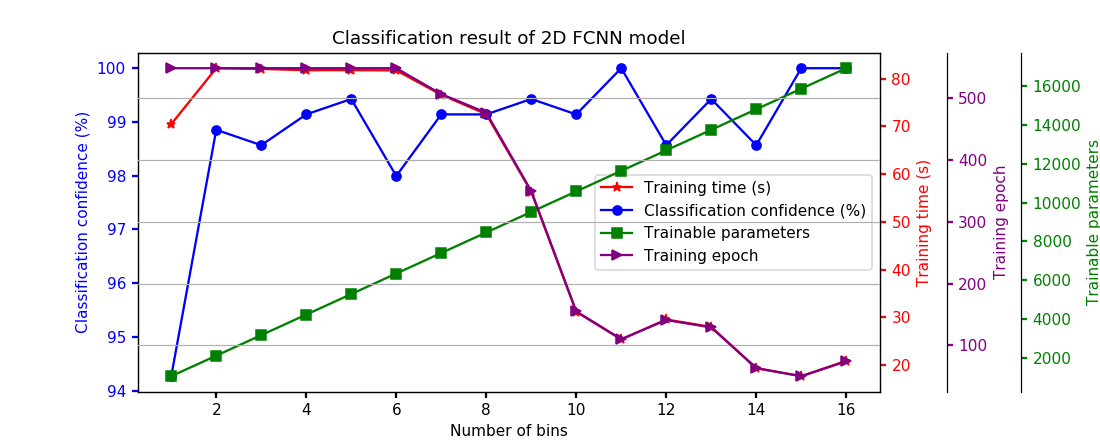

In [42]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, host = plt.subplots(figsize=(10,4))
fig.subplots_adjust(right=0.8)

par1 = host.twinx()
par2 = host.twinx()
par3 = host.twinx()

par2.spines["right"].set_position(("axes", 1.19))
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)

par3.spines["right"].set_position(("axes", 1.09))
make_patch_spines_invisible(par3)
par3.spines["right"].set_visible(True)

p1, = host.plot(B_num, GLO_ACC *100,'bo-',color='blue',label='Classification confidence (%)')
p1_1, = par1.plot(B_num, GLO_TrnT,'*-',color='red',label='Training time (s)')
p2, = par2.plot(B_num, GLO_Prm,'gs-',color='green',label='Trainable parameters')
p3, = par3.plot(B_num, TRN_Epoch,'>-',color='purple',label='Training epoch')

host.set_xlabel("Number of bins")
host.set_ylabel("Classification confidence (%)")
par1.set_ylabel("Training time (s)")
par2.set_ylabel("Trainable parameters")
par3.set_ylabel("Training epoch")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p1_1.get_color())
par2.yaxis.label.set_color(p2.get_color())
par3.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p1_1.get_color(), **tkw)
par2.tick_params(axis='y', colors=p2.get_color(), **tkw)
par3.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

# par1.set_ylim(170,180)
# plt.subplots_adjust(bottom=0.15)

lines = [p1_1,p1, p2, p3]

host.legend(lines, [l.get_label() for l in lines],loc='center right')
plt.title('Classification result of 2D FCNN model')
plt.grid(True)
plt.savefig(save_figures_to+"Classification result of 2D FCNN model.svg")

# just for test

In [ ]:
  

class MultiBinSegm(nn.Module):
    def __init__(self, n_feature=128,  O_channel=16, O_feature=2,output_dim = 1, hidden_size = 150, BinNum = B):
        super(MultiBinSegm,self).__init__()
        self.BinNum = BinNum
        self.conv1 = nn.Sequential(nn.Conv1d(1, n_feature, kernel_size=3),
                                   nn.ReLU(),
                                   nn.MaxPool1d(2)
                                   )
#         self.conv2 = nn.Sequential(nn.Conv1d(n_feature, n_feature, kernel_size=5),
#                                    nn.ReLU(),
#                                    nn.MaxPool1d(2)
#                                    )
        self.conv3 = nn.Sequential(nn.Conv1d(n_feature, O_channel, kernel_size=3),
                                   nn.ReLU(),
                                   nn.MaxPool1d(1)
                                   )
        input_shape = (1, 1, N2) # just for test, in order to get the shape of FNN input neurons            
        self.output_dimension = self._get_conv_output(input_shape)
               
#         self.fc1 = nn.Sequential(
#             nn.Linear(self.output_dimension, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, O_feature),            
#             nn.Sigmoid()
# #             nn.Dropout(0.5)
#         )
            
        self.fc1 = nn.Sequential(
            nn.Linear(self.output_dimension, O_feature),          
            nn.Sigmoid()
        )
        
        self._create_weights()
        
#         self.ConvNet = nn.ModuleList()
#         for _ in range(BinNum):
#             ConvBinnet = nn.Sequential(
#                 self.conv1,
#                 self.conv2,
#                 self.conv3,
#                 self.fc1
#             )
#             self.ConvNet.append(ConvBinnet)
            

        self.fc1nets = nn.Sequential(
            nn.Linear(O_feature*B, output_dim),
            nn.Sigmoid()
        )
     

    def _create_weights(self, mean=0.0, std=0.05):
        for module in self.modules():
            if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
                module.weight.data.normal_(mean, std) 
                
    def _get_conv_output(self, shape):
        x = torch.rand(shape)
        x = self.conv1(x)
#         x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output_dimension = x.size(1)
        return output_dimension
    
    def forward(self, x):
#         Out1 = torch.empty(O_feature,0)
        Out1 = torch.empty(x.shape[0],0)
        for b in range(self.BinNum): # Different input for different bin.
            In_Conv = x[:,b*N2:(b+1)*N2]
            In_Conv = torch.reshape(In_Conv,(-1,1,N2))
            In_Conv  = self.conv1(In_Conv)  
#             In_Conv  = self.conv2(In_Conv)
            In_Conv  = self.conv3(In_Conv)
            In_Conv  = In_Conv.view(In_Conv.size(0), -1)
            In_Conv  = self.fc1(In_Conv)
            Out1    = torch.cat([Out1, In_Conv], dim=1)
        Out2 = self.fc1nets(Out1)
        return Out2

      

OUT_Dim =1  
O_FeatCOV=6
model = MultiBinSegm(
    n_feature = n_feature,
    output_dim = OUT_Dim,
    hidden_size = H,
    O_feature=O_FeatCOV,
    BinNum = B
)
model.to(device)
# x = torch.randn(BATCH_SIZE, IN_DIM)